# Anomality detection results


In [50]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from scipy.spatial.distance import mahalanobis
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Trained w/ ASD (New setup)


In [55]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

support_data = []
query_data = []
ensemble_size = 5

for i in range(ensemble_size):
    query_data.append(
        pd.read_feather(
            os.path.join(
                data_folder,
                # "anomality_detection_arotor_replication",
                "anomality_detection_arotor_replication_norm_new",
                # "anomality_detection_arotor_replication_acc3",
                # "anomality_detection_arotor_replication_acc3_32",
                # "anomality_detection_arotor_replication_acc3_32_norm",
                # "anomality_detection_arotor_replication_acc3_32_norm_new",
                f"query_{i}.feather",
            )
        )
    )

print("ensemble size", len(query_data))
print("query", query_data[0].shape)

fault_GP_map = {
    "mild_micropitting": 4,
    "severe_micropitting": 3,
    "mild_pitting": 1,
    "severe_pitting": 6,
    "mild_wear": 7,
    "severe_wear": 2,
    "mild_tff": 9,
    "severe_tff": 5,
}


def distance_mahalanobis(prototype, queries, inv_cm):
    return np.array([mahalanobis(x, prototype, inv_cm) for x in queries])


def distance(prototype, queries):
    return np.sum((queries - prototype) ** 2, axis=1)

ensemble size 5
query (34017, 21)


In [56]:
query_data[0]

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,fault,severity,rpm,torque,installation
0,0.229016,1.219142,33.451138,8.499253,0.000000,0.143483,39.372627,3.482638,1.546030,0.020500,...,3.993784,53.525471,0.271841,3.488323,6.238514,baseline,1,500,1,0
1,0.211310,1.124403,33.828716,8.470195,0.000000,0.084192,39.674717,3.478216,1.612168,0.017901,...,3.732322,52.784134,0.336146,3.885870,6.368388,baseline,1,500,1,0
2,0.212894,1.068572,33.993122,8.501136,0.000000,0.107437,39.938007,3.479358,1.758473,0.027500,...,3.533202,52.454620,0.396101,4.170022,6.586019,baseline,1,500,1,0
3,0.251201,1.125084,34.041992,8.692812,0.000000,0.134991,40.065964,3.450805,1.883982,0.019178,...,3.638381,52.281616,0.476668,4.446842,6.667520,baseline,1,500,1,0
4,0.244084,1.126932,34.155487,8.549640,0.000254,0.103020,40.061993,3.443690,1.795023,0.014503,...,3.605395,52.183048,0.485843,4.395522,6.595238,baseline,1,500,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,14.795987,0.338786,35.826744,19.507097,7.809468,3.432130,44.294594,16.956127,24.202749,1.816803,...,2.166024,32.564907,18.001938,15.832135,20.605282,wear,severe,1500,11,2
151,14.586860,0.339457,35.925579,19.466797,7.674479,3.441403,44.352039,16.772690,23.862305,1.771558,...,2.136477,32.788803,17.816647,15.710966,20.460140,wear,severe,1500,11,2
152,14.771749,0.344304,35.841923,19.499088,7.713291,3.451758,44.335892,17.043842,24.181198,1.863109,...,2.211907,32.617153,17.955826,15.802744,20.683142,wear,severe,1500,11,2
153,14.706887,0.359271,35.841385,19.522194,7.722066,3.418375,44.350834,16.975269,24.133835,1.814658,...,2.193622,32.634048,17.907417,15.774061,20.664886,wear,severe,1500,11,2


In [57]:
rpm = 1500
torque = 6
severity = "mild"
faults = ["micropitting", "pitting", "wear", "tff"]
# installation = [1]
installation = [1, 2]
# GPs = [2, 3, 5, 6]

ensemble_support_groups = []
ensemble_query_healthy_groups = []
ensemble_query_groups = []

for i in range(ensemble_size):
    ensemble_support_groups.append({})
    ensemble_query_healthy_groups.append({})
    ensemble_query_groups.append({})

    for fault in faults:
        # SUPPORT #
        support_group = (
            query_data[i][
                (query_data[i]["rpm"] == rpm)
                & (
                    query_data[i]["severity"]
                    == str(fault_GP_map[f"{severity}_{fault}"])
                )
                & (query_data[i]["torque"] == torque)
            ]
            .drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
            .to_numpy()
        )

        ensemble_support_groups[i][f"{severity}_{fault}"] = support_group[
            : support_group.shape[0] // 2
        ]

        # QUERY BASELINE #
        ensemble_query_healthy_groups[i][f"{severity}_{fault}"] = support_group[
            support_group.shape[0] // 2 :
        ]

        # QUERY FAULTS #
        query_group = (
            query_data[i][
                (query_data[i]["rpm"] == rpm)
                & (query_data[i]["severity"] == severity)
                & (query_data[i]["torque"] == torque)
                & (query_data[i]["installation"].isin(installation))
                & (query_data[i]["fault"] == fault)
            ]
            .drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
            .to_numpy()
        )

        ensemble_query_groups[i][f"{severity}_{fault}"] = query_group

> micropitting
SUPPORT
Mean:    11.42
Max:     26.62
Min:      2.92

QUERY
Mean:  4368.34 |    17.06
Max:   8575.83 |    28.93
Min:     69.61 |     6.04

> pitting
SUPPORT
Mean:     5.12
Max:      8.53
Min:      2.53

QUERY
Mean:   463.46 |    17.56
Max:    670.74 |    38.46
Min:    251.06 |     4.03

> wear
SUPPORT
Mean:     5.34
Max:     10.33
Min:      2.48

QUERY
Mean:    90.33 |     9.88
Max:    144.13 |    22.84
Min:     50.92 |     3.90

> tff
SUPPORT
Mean:     5.62
Max:     11.15
Min:      2.17

QUERY
Mean:    72.40 |    19.51
Max:    114.45 |    34.67
Min:     43.51 |     6.95



/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_9633/2641318965.py:130: UserWarning: The palette list has more values (12) than needed (3), which may not be intended.
  sns.catplot(


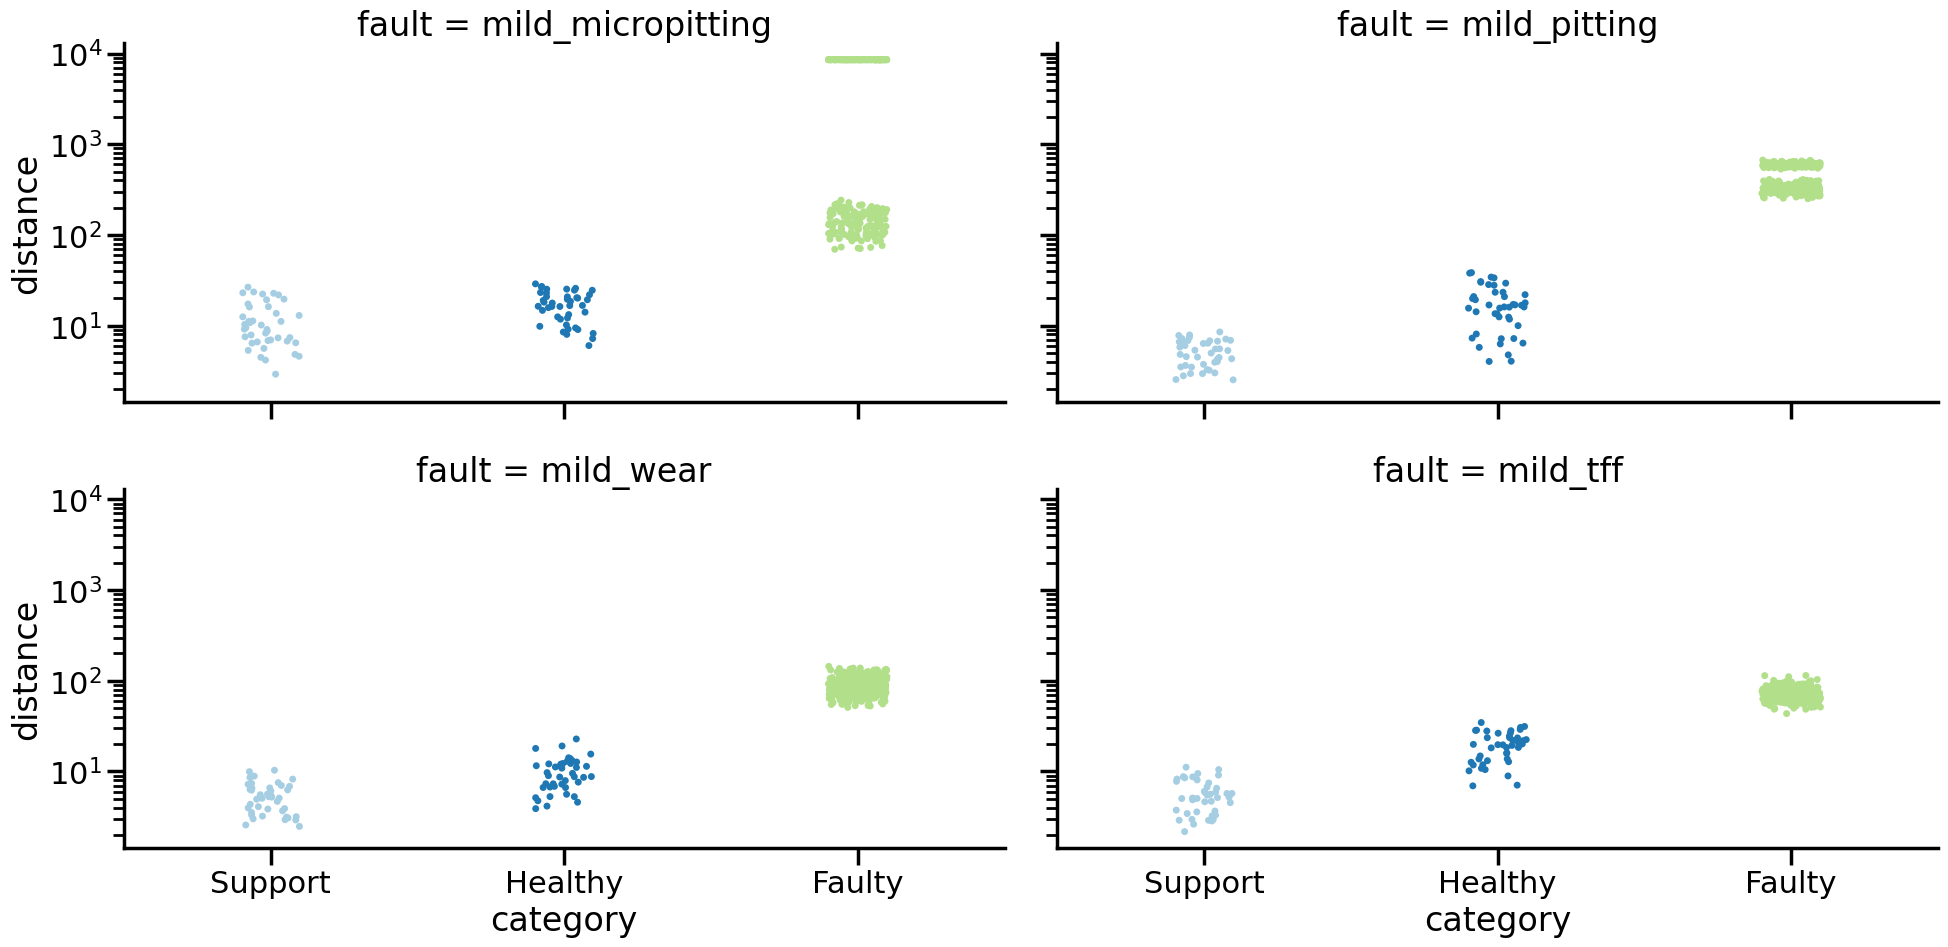

In [58]:
distance_metric = "L2"

all_support_distances = {}
all_query_healthy_distances = {}
all_query_distances = {}

for fault in faults:
    print(f"> {fault}")
    print("SUPPORT")

    ensemble_support_distances = []
    prototypes = []
    support_inv_cms = []

    # Ensemble loop
    for i in range(ensemble_size):
        prototype = ensemble_support_groups[i][f"{severity}_{fault}"].mean(axis=0)
        prototypes.append(prototype)

        # Calculate distance
        if distance_metric == "L2":
            support_distances = distance(
                prototype, ensemble_support_groups[i][f"{severity}_{fault}"]
            )
        elif distance_metric == "mahalanobis":
            support_inv_cm = np.linalg.inv(
                np.cov(ensemble_support_groups[i][f"{severity}_{fault}"], rowvar=False)
            )
            support_inv_cms.append(support_inv_cm)
            support_distances = distance_mahalanobis(
                prototype,
                ensemble_support_groups[i][f"{severity}_{fault}"],
                support_inv_cm,
            )
        else:
            raise Exception("WAT")
        ensemble_support_distances.append(support_distances)

    # Ensemble average
    mean_support_distances = np.stack(ensemble_support_distances, axis=-1).mean(axis=-1)
    all_support_distances[f"{severity}_{fault}"] = mean_support_distances

    print("Mean: {:>8.2f}".format(mean_support_distances.mean()))
    print("Max:  {:>8.2f}".format(mean_support_distances.max()))
    print("Min:  {:>8.2f}".format(mean_support_distances.min()))
    print()

    print("QUERY")

    ensemble_query_healthy_distances = []
    ensemble_query_distances = []

    for i in range(ensemble_size):
        if distance_metric == "L2":
            # Query healthy
            query_healthy_distances = distance(
                prototypes[i], ensemble_query_healthy_groups[i][f"{severity}_{fault}"]
            )
            # Faults
            query_distances = distance(
                prototypes[i], ensemble_query_groups[i][f"{severity}_{fault}"]
            )
        elif distance_metric == "mahalanobis":
            # Query healthy
            query_healthy_distances = distance_mahalanobis(
                prototypes[i],
                ensemble_query_healthy_groups[i][f"{severity}_{fault}"],
                support_inv_cms[i],
            )
            # Faults
            query_distances = distance_mahalanobis(
                prototypes[i],
                ensemble_query_groups[i][f"{severity}_{fault}"],
                support_inv_cms[i],
            )
        ensemble_query_healthy_distances.append(query_healthy_distances)
        ensemble_query_distances.append(query_distances)

    # Ensemble averages
    mean_query_healthy_distances = np.stack(
        ensemble_query_healthy_distances, axis=-1
    ).mean(axis=-1)
    all_query_healthy_distances[f"{severity}_{fault}"] = mean_query_healthy_distances

    mean_query_distances = np.stack(ensemble_query_distances, axis=-1).mean(axis=-1)
    all_query_distances[f"{severity}_{fault}"] = mean_query_distances

    print(
        "Mean: {:>8.2f} | {:>8.2f}".format(
            mean_query_distances.mean(), mean_query_healthy_distances.mean()
        )
    )
    print(
        "Max:  {:>8.2f} | {:>8.2f}".format(
            mean_query_distances.max(), mean_query_healthy_distances.max()
        )
    )
    print(
        "Min:  {:>8.2f} | {:>8.2f}".format(
            mean_query_distances.min(), mean_query_healthy_distances.min()
        )
    )
    print()

# Plotting

# fig, axs = plt.subplots(len(faults), figsize=(15, 20))

df = []
for i, fault in enumerate(faults):
    full_fault = f"{severity}_{fault}"

    tmp_1 = pd.DataFrame(all_support_distances[full_fault], columns=["distance"])
    tmp_1["category"] = "Support"
    tmp_1["fault"] = full_fault
    tmp_2 = pd.DataFrame(all_query_healthy_distances[full_fault], columns=["distance"])
    tmp_2["category"] = "Healthy"
    tmp_2["fault"] = full_fault
    tmp_3 = pd.DataFrame(all_query_distances[full_fault], columns=["distance"])
    tmp_3["category"] = "Faulty"
    tmp_3["fault"] = full_fault

    df.append(tmp_1)
    df.append(tmp_2)
    df.append(tmp_3)

df = pd.concat(df)

with sns.plotting_context("poster"):
    sns.catplot(
        df,
        x="category",
        y="distance",
        hue="category",
        col="fault",
        col_wrap=2,
        log_scale=True,
        height=5,
        aspect=2,
        palette=sns.color_palette("Paired"),
        legend=False,
    )

---


# Trained w/ ASD


In [2]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

support_data = []
query_data = []
ensemble_size = 5

for i in range(ensemble_size):
    support_data.append(
        pd.read_feather(
            os.path.join(
                data_folder,
                # "anomality_detection_arotor_replication",
                # "anomality_detection_arotor_replication_acc3",
                "anomality_detection_arotor_replication_acc3_32",
                # "anomality_detection_arotor_replication_acc3_32_norm",
                f"support_{i}.feather",
            )
        )
    )

    query_data.append(
        pd.read_feather(
            os.path.join(
                data_folder,
                # "anomality_detection_arotor_replication",
                # "anomality_detection_arotor_replication_acc3",
                "anomality_detection_arotor_replication_acc3_32",
                # "anomality_detection_arotor_replication_acc3_32_norm",
                f"query_{i}.feather",
            )
        )
    )

print("ensemble size", len(support_data))
print("support", support_data[0].shape)
print("query", query_data[0].shape)

ensemble size 5
support (3410, 35)
query (30607, 37)


In [3]:
rpm = 1500
torque = 6
support_GP = [1, 2, 3, 4]
query_GP = ["5", "6", "7", "8", "9"]
# query_GP = ["8"]
severity = "severe"
# installation = [1]
installation = [1, 2]
faults = ["micropitting", "pitting", "wear", "tff"]

ensemble_support_groups = []
ensemble_query_groups = []

for i in range(ensemble_size):
    # SUPPORT #
    support_group = support_data[i][
        (support_data[i]["rpm"] == rpm)
        & (support_data[i]["GP"].isin(support_GP))
        & (support_data[i]["torque"] == torque)
    ].drop(["rpm", "GP", "torque"], axis=1)
    ensemble_support_groups.append(support_group.to_numpy())
    # support_group = support_group.to_numpy()

    # QUERY #
    query_groups = []

    # Baseline
    query_group = query_data[i][
        (query_data[i]["rpm"] == rpm)
        & (query_data[i]["severity"].isin(query_GP))
        & (query_data[i]["torque"] == torque)
        & (query_data[i]["installation"] == 0)  # All baseline in installation 0
        & (query_data[i]["fault"] == "baseline")
    ].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
    query_group = query_group.to_numpy()
    query_groups.append(query_group)

    # Faults
    for fault in faults:
        query_group = query_data[i][
            (query_data[i]["rpm"] == rpm)
            & (query_data[i]["severity"] == severity)
            & (query_data[i]["torque"] == torque)
            & (query_data[i]["installation"].isin(installation))
            & (query_data[i]["fault"] == fault)
        ].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
        query_group = query_group.to_numpy()

        query_groups.append(query_group)

    ensemble_query_groups.append(query_groups)

In [21]:
qwe = np.cov(ensemble_support_groups[i], rowvar=False)
np.linalg.det(qwe)
# np.diag(qwe)

0.0

In [27]:
unq, count = np.unique(qwe.T, axis=0, return_counts=True)
unq[count > 1]

array([], shape=(0, 32), dtype=float64)

In [22]:
ensemble_support_groups[i]

array([[ 890.15063,  535.95605, 1355.3163 , ..., 1594.0319 ,  438.20807,
         433.77396],
       [ 896.63544,  530.586  , 1373.2576 , ..., 1607.3588 ,  431.86   ,
         417.0184 ],
       [ 892.677  ,  527.3184 , 1373.0566 , ..., 1608.4913 ,  447.24585,
         414.59662],
       ...,
       [ 704.4161 ,  450.7141 , 1068.6996 , ..., 1208.7173 ,  349.09372,
         323.17538],
       [ 705.8471 ,  445.23553, 1044.555  , ..., 1193.9315 ,  330.0823 ,
         310.86758],
       [ 710.3367 ,  441.83105, 1039.9929 , ..., 1192.6602 ,  348.81665,
         320.39923]], dtype=float32)

### Distances


SUPPORT
Mean: 3445780.2
Max: 10203715.0
Min: 238836.25

QUERY
Healthy
Mean: 12949450.0
Max: 39527516.0
Min: 434501.3
Micropitting
Mean: 31539038.0
Max: 71305740.0
Min: 3943340.5
Pitting
Mean: 25442470.0
Max: 49381348.0
Min: 6977620.0
Wear
Mean: 4832364.5
Max: 11125134.0
Min: 406983.22
TFF
Mean: 561991900.0
Max: 999101950.0
Min: 229573680.0


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_7466/2715694310.py:71: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  sns.catplot(


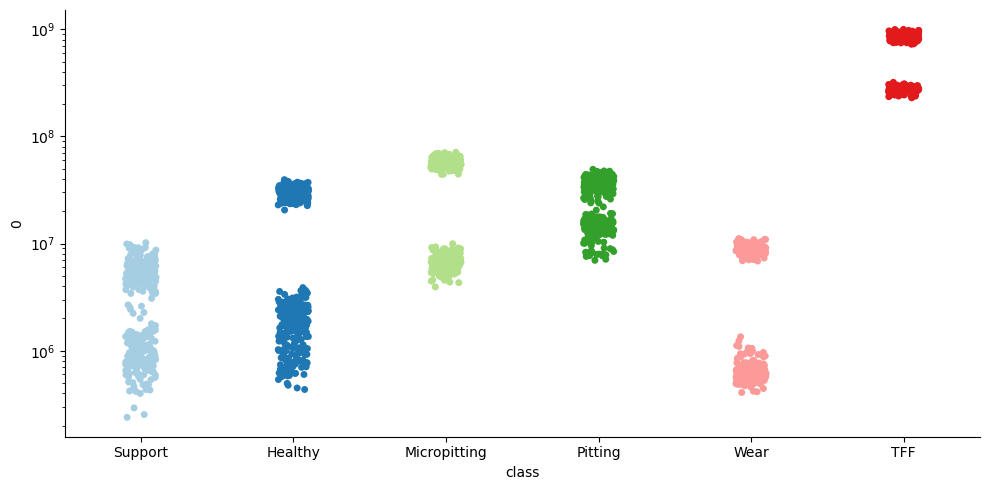

In [4]:
print("SUPPORT")
ensemble_support_distances = []
prototypes = []
support_inv_cms = []
for i in range(ensemble_size):
    prototype = ensemble_support_groups[i].mean(axis=0)
    prototypes.append(prototype)

    # Mahalanobis
    # support_inv_cm = np.linalg.inv(np.cov(ensemble_support_groups[i], rowvar=False))
    # support_inv_cms.append(support_inv_cm)
    # support_distances = distance_mahalanobis(
    #     prototype, ensemble_support_groups[i], support_inv_cm
    # )
    # L2
    support_distances = distance(prototype, ensemble_support_groups[i])
    ensemble_support_distances.append(support_distances)

# Ensemble average
support_distances = np.stack(ensemble_support_distances, axis=-1).mean(axis=-1)

print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

print("QUERY")
fault_map = ["Healthy", "Micropitting", "Pitting", "Wear", "TFF"]
query_distances = {}
for i in range(len(fault_map)):
    print(fault_map[i])
    ensemble_distances = []
    for j in range(ensemble_size):
        # Mahalanobis
        # ensemble_distances.append(
        #     distance_mahalanobis(
        #         prototypes[j], ensemble_query_groups[j][i], support_inv_cms[j]
        #     )
        # )
        # L2
        ensemble_distances.append(distance(prototypes[j], ensemble_query_groups[j][i]))

    # Ensemble average
    query_distances[fault_map[i]] = np.stack(ensemble_distances, axis=-1).mean(axis=-1)

    print("Mean:", query_distances[fault_map[i]].mean())
    print("Max:", query_distances[fault_map[i]].max())
    print("Min:", query_distances[fault_map[i]].min())

    # Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in fault_map:
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df,
    x="class",
    y=0,
    hue="class",
    log_scale=True,
    height=5,
    aspect=2,
    palette=sns.color_palette("Paired"),
    legend=False,
)

In [174]:
def distance_mahalanobis(prototype, queries, inv_cm):
    return np.array([mahalanobis(x, prototype, inv_cm) for x in queries])


def distance(prototype, queries):
    return np.sum((queries - prototype) ** 2, axis=1)


print("SUPPORT")
ensemble_support_distances = []
prototypes = []
support_inv_cms = []
for i in range(ensemble_size):
    prototype = ensemble_support_groups[i].mean(axis=0)
    prototypes.append(prototype)

    # Mahalanobis
    support_inv_cm = np.linalg.inv(np.cov(ensemble_support_groups[i], rowvar=False))
    support_inv_cms.append(support_inv_cm)
    support_distances = distance_mahalanobis(
        prototype, ensemble_support_groups[i], support_inv_cm
    )
    # L2
    # support_distances = distance(prototype, ensemble_support_groups[i])
    ensemble_support_distances.append(support_distances)

# Ensemble average
support_distances = np.stack(ensemble_support_distances, axis=-1).mean(axis=-1)

print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

print("QUERY")
fault_map = ["Healthy", "Micropitting", "Pitting", "Wear", "TFF"]
query_distances = {}
for i in range(len(fault_map)):
    print(fault_map[i])
    ensemble_distances = []
    for j in range(ensemble_size):
        # Mahalanobis
        ensemble_distances.append(
            distance_mahalanobis(
                prototypes[j], ensemble_query_groups[j][i], support_inv_cms[j]
            )
        )
        # L2
        # ensemble_distances.append(distance(prototypes[j], ensemble_query_groups[j][i]))

    # Ensemble average
    query_distances[fault_map[i]] = np.stack(ensemble_distances, axis=-1).mean(axis=-1)

    print("Mean:", query_distances[fault_map[i]].mean())
    print("Max:", query_distances[fault_map[i]].max())
    print("Min:", query_distances[fault_map[i]].min())

    # Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in fault_map:
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df,
    x="class",
    y=0,
    hue="class",
    log_scale=True,
    height=5,
    aspect=2,
    palette=sns.color_palette("Paired"),
    legend=False,
)

SUPPORT


LinAlgError: Singular matrix

SUPPORT
Mean: 3.3392503
Max: 9.149887
Min: 0.70306313

Healthy
Mean: 4.3589177
Max: 9.730363
Min: 0.6773419
Micropitting
Mean: 7.221403
Max: 12.1260195
Min: 3.8277128
Pitting
Mean: 5.4383373
Max: 8.571107
Min: 2.835105
Wear
Mean: 8.636745
Max: 15.101037
Min: 2.8056972
TFF
Mean: 27.841484
Max: 71.712944
Min: 11.674653


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_91810/1059662015.py:32: UserWarning:

The palette list has more values (12) than needed (6), which may not be intended.



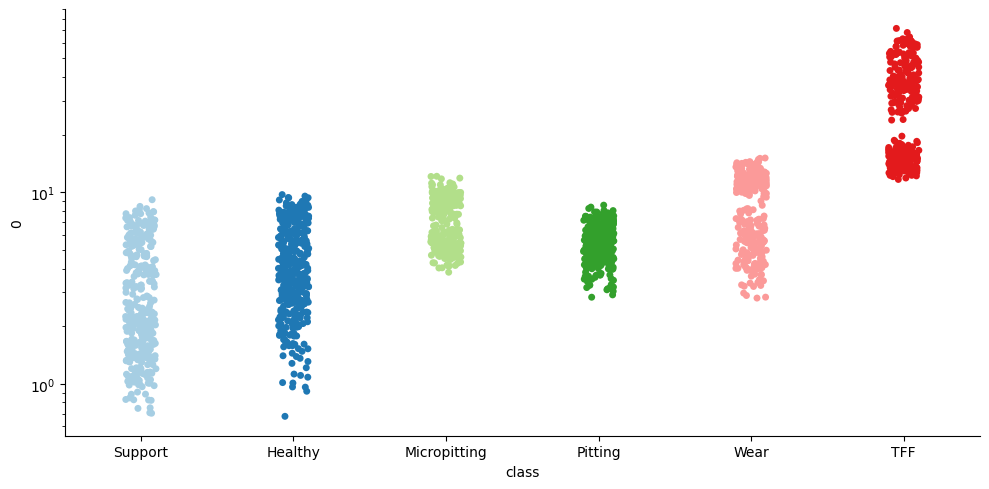

In [107]:
#! NON-ENSEMBLE IMPLEMENTATION #

prototype = support_group.mean(axis=0)

print("SUPPORT")
support_distances = np.sum((support_group - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
fault_map = ["Healthy", "Micropitting", "Pitting", "Wear", "TFF"]
for i in range(5):
    print(fault_map[i])
    query_distances[fault_map[i]] = np.sum((query_groups[i] - prototype) ** 2, axis=1)
    print("Mean:", query_distances[fault_map[i]].mean())
    print("Max:", query_distances[fault_map[i]].max())
    print("Min:", query_distances[fault_map[i]].min())

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in fault_map:
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df,
    x="class",
    y=0,
    hue="class",
    log_scale=True,
    height=5,
    aspect=2,
    palette=sns.color_palette("Paired"),
    legend=False,
)

### 2D TSNE


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_91810/3182773687.py:19: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(


<Axes: xlabel='x', ylabel='y'>

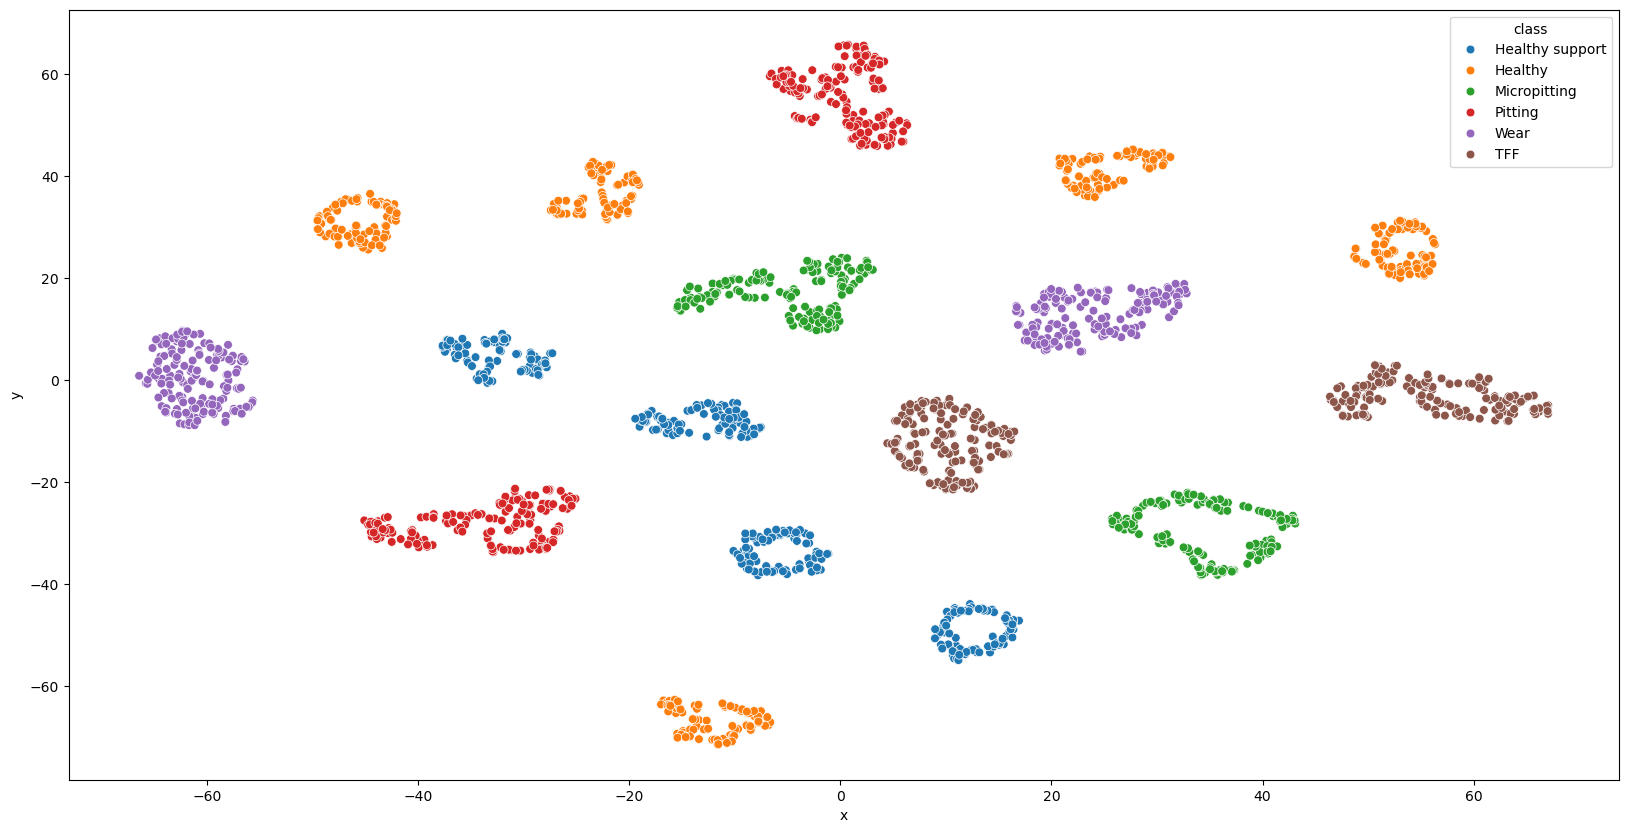

In [69]:
tsne_embeddings = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=20
).fit_transform(np.concatenate([support_group, *query_groups]))
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["Healthy support"],
        len(query_groups[0]) * ["Healthy"],
        len(query_groups[1]) * ["Micropitting"],
        len(query_groups[2]) * ["Pitting"],
        len(query_groups[3]) * ["Wear"],
        len(query_groups[4]) * ["TFF"],
    ]
)

plt.figure(figsize=(20, 10))
palette = sns.color_palette()

sns.scatterplot(
    tsne_embeddings,
    x="x",
    y="y",
    s=40,
    hue="class",
    palette=palette,
    alpha=1.0,
    legend=True,
)

### 3D TSNE


In [119]:
tsne_embeddings = TSNE(
    n_components=3, learning_rate="auto", init="random", perplexity=20
).fit_transform(np.concatenate([support_group, *query_groups]))
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y", "z"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["Healthy support"],
        len(query_groups[0]) * ["Healthy"],
        len(query_groups[1]) * ["Micropitting"],
        len(query_groups[2]) * ["Pitting"],
        len(query_groups[3]) * ["Wear"],
        len(query_groups[4]) * ["TFF"],
    ]
)

fig = px.scatter_3d(
    tsne_embeddings, x="x", y="y", z="z", color="class", width=1200, height=1200
)
fig.show()

### 3D PCA


In [120]:
pca = PCA(n_components=3)
pca.fit(support_group[:50])

pca_embeddings = pca.transform(np.concatenate([support_group, *query_groups]))

pca_embeddings = pd.DataFrame(pca_embeddings, columns=["x", "y", "z"])
pca_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["Healthy support"],
        len(query_groups[0]) * ["Healthy"],
        len(query_groups[1]) * ["Micropitting"],
        len(query_groups[2]) * ["Pitting"],
        len(query_groups[3]) * ["Wear"],
        len(query_groups[4]) * ["TFF"],
    ]
)


fig = px.scatter_3d(
    pca_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1200,
    height=1200,
    color_discrete_sequence=sns.color_palette("Paired").as_hex(),
)
fig.show()

# Trained w/ AGFD


In [27]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

support_data = pd.read_feather(
    os.path.join(
        data_folder,
        "anomality_detection_arotor_12-12_17-38-52",
        "support_0.feather",
    )
)
query_data = pd.read_feather(
    os.path.join(
        data_folder,
        "anomality_detection_arotor_12-12_17-38-52",
        "query_0.feather",
    )
)

print("support", support_data.shape)
print("query", query_data.shape)

support (208, 18)
query (3952, 18)


In [28]:
rpm = 1500

# SUPPORT #

support_group = support_data[(support_data["rpm"] == rpm)].drop(
    ["rpm", "class"], axis=1
)
support_group = support_group.to_numpy()

# QUERY #

query_groups = {}

for i in range(10):
    query_group = query_data[
        (query_data["rpm"] == rpm) & (query_data["class"] == i)
    ].drop(["rpm", "class"], axis=1)
    query_groups[i] = query_group.to_numpy()

### 2D TSNE


(52, 16)
(104, 16)


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_71080/2370985312.py:15: UserWarning:


The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.



<Axes: xlabel='x', ylabel='y'>

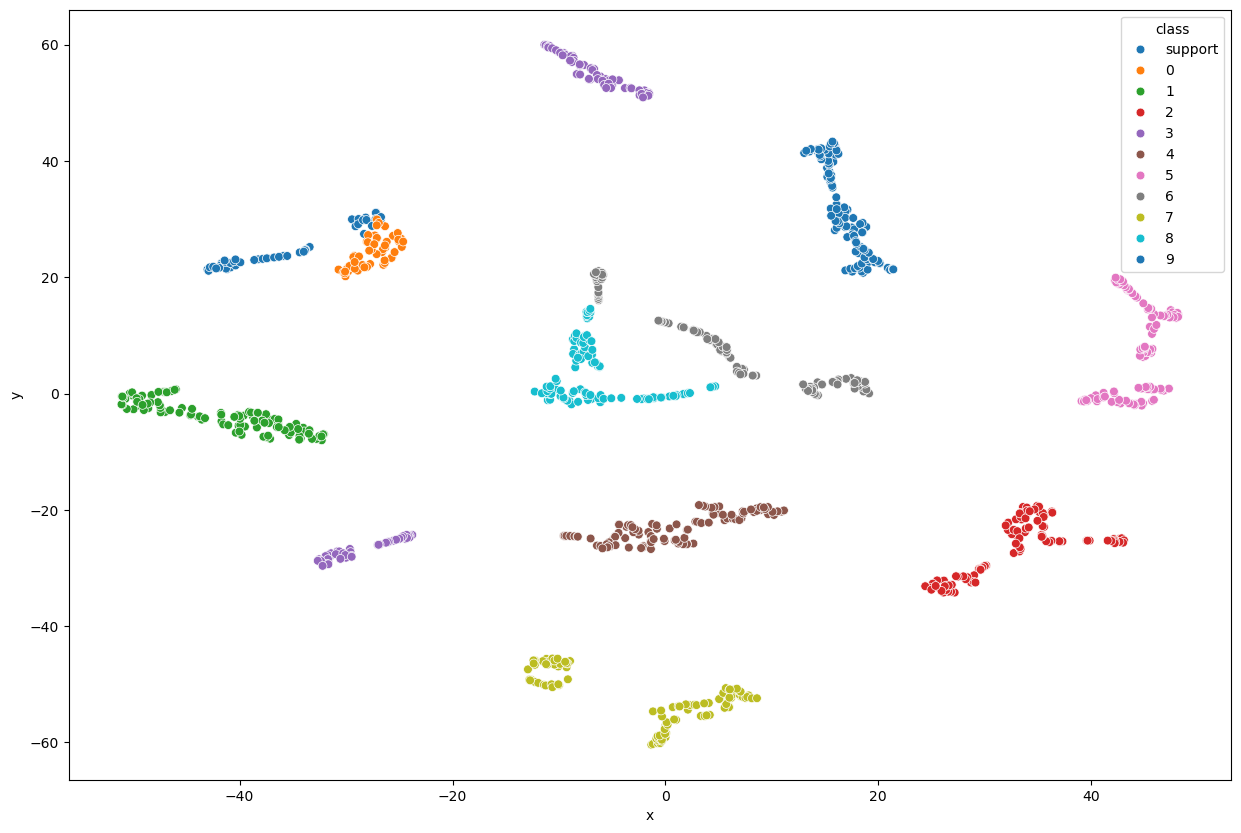

In [29]:
print(support_group.shape)
print(query_group.shape)

tsne_embeddings = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=20
).fit_transform(np.concatenate([support_group, *[query_groups[i] for i in range(10)]]))
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y"])
tsne_embeddings["class"] = np.concatenate(
    [len(support_group) * ["support"], *[len(query_groups[i]) * [i] for i in range(10)]]
)

plt.figure(figsize=(15, 10))
palette = sns.color_palette()

sns.scatterplot(
    tsne_embeddings,
    x="x",
    y="y",
    s=40,
    hue="class",
    palette=palette,
    alpha=1.0,
    legend=True,
)

### 3D TSNE


In [30]:
tsne_embeddings = TSNE(
    n_components=3, learning_rate="auto", init="random", perplexity=20
).fit_transform(np.concatenate([support_group, *[query_groups[i] for i in range(10)]]))
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y", "z"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["support"],
        *[len(query_groups[i]) * [i] for i in range(10)],
    ]
)

fig = px.scatter_3d(
    tsne_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1000,
    height=1000,
    color_discrete_sequence=px.colors.qualitative.Light24,
)
fig.show()

### 3D PCA


In [31]:
pca = PCA(n_components=3)
pca.fit(support_group)

pca_embeddings = pca.transform(
    np.concatenate([support_group, *[query_groups[i] for i in range(10)]])
)

pca_embeddings = pd.DataFrame(pca_embeddings, columns=["x", "y", "z"])
pca_embeddings["class"] = np.concatenate(
    [len(support_group) * ["support"], *[len(query_groups[i]) * [i] for i in range(10)]]
)


fig = px.scatter_3d(
    pca_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1000,
    height=600,
    color_discrete_sequence=sns.color_palette("Paired").as_hex(),
    # color_discrete_sequence=px.colors.qualitative.Light24,
)
fig.show()

### Distances


SUPPORT
Mean: 16.93671
Max: 42.94537
Min: 1.0246133

0
Mean: 19.827328
Max: 39.675175
Min: 7.8753076
1
Mean: 1704.935
Max: 2164.3118
Min: 1250.8705
2
Mean: 4294.254
Max: 5830.092
Min: 3456.9822
3
Mean: 64093.36
Max: 85749.18
Min: 51463.008
4
Mean: 5297.435
Max: 7478.2627
Min: 3572.6733
5
Mean: 43555.9
Max: 54491.246
Min: 30182.012
6
Mean: 87081.516
Max: 104941.445
Min: 65232.098
7
Mean: 7902.1694
Max: 9748.569
Min: 6217.2466
8
Mean: 81551.71
Max: 93068.94
Min: 74672.695
9
Mean: 198619.6
Max: 217978.33
Min: 175300.52


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_71080/3057055446.py:31: UserWarning:

The palette list has more values (12) than needed (11), which may not be intended.



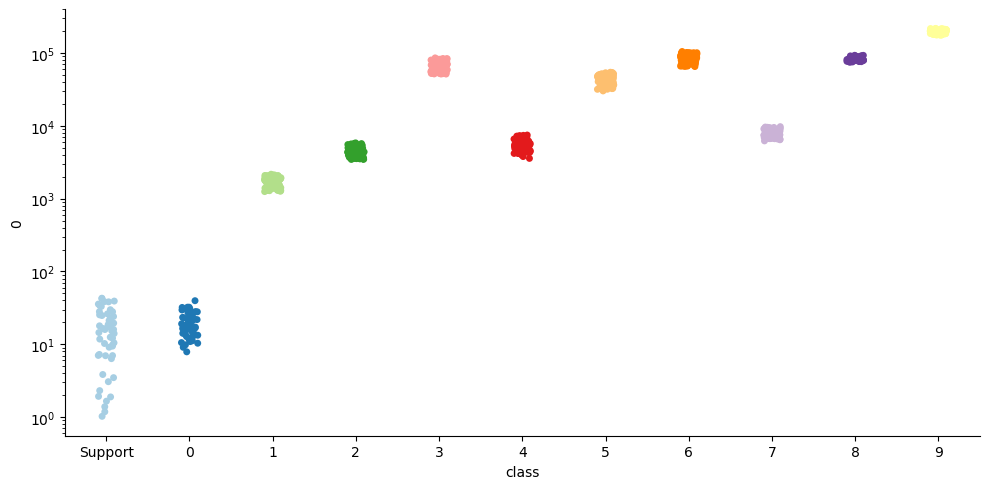

In [32]:
prototype = support_group.mean(axis=0)

print("SUPPORT")
support_distances = np.sum((support_group - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in range(10):
    print(fault)
    query_distances[fault] = np.sum((query_groups[fault] - prototype) ** 2, axis=1)
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in range(10):
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df,
    x="class",
    y=0,
    hue="class",
    log_scale=True,
    height=5,
    aspect=2,
    legend=False,
    palette=sns.color_palette("Paired"),
)

---

# OLD


# ARotor replication


In [17]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

support_data = pd.read_feather(
    # os.path.join(data_folder, "anomality_detection_arotor_replication_10-18_17-34-48", "support_0.feather")
    os.path.join(
        data_folder,
        "anomality_detection_arotor_replication_10-25_12-55-17",
        "support_0.feather",
    )
)
query_data = pd.read_feather(
    # os.path.join(data_folder, "anomality_detection_arotor_replication_10-18_17-34-48", "query_0.feather")
    os.path.join(
        data_folder,
        "anomality_detection_arotor_replication_10-25_12-55-17",
        "query_0.feather",
    )
)

print("support", support_data.shape)
print("query", query_data.shape)

support (3410, 67)
query (30607, 69)


## Figures


In [18]:
support_group = support_data[
    (support_data["rpm"] == 1500)
    & (support_data["GP"].isin([1, 2, 3, 4]))
    & (support_data["torque"] == 1)
].drop(["rpm", "GP", "torque"], axis=1)
support_group = support_group.to_numpy()

query_group = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "tff")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group = query_group.to_numpy()

query_group_2 = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "wear")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group_2 = query_group_2.to_numpy()

query_group_3 = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "pitting")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group_3 = query_group_3.to_numpy()

query_group_4 = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "micropitting")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group_4 = query_group_4.to_numpy()

query_group_5 = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "mild")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "tff")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group_5 = query_group_5.to_numpy()

query_group_6 = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "8")
    & (query_data["torque"] == 1)
    & (query_data["installation"] == 0)
    & (query_data["fault"] == "baseline")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group_6 = query_group_6.to_numpy()

/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_69976/3833122620.py:18: UserWarning:

The palette list has more values (10) than needed (5), which may not be intended.



<Axes: xlabel='x', ylabel='y'>

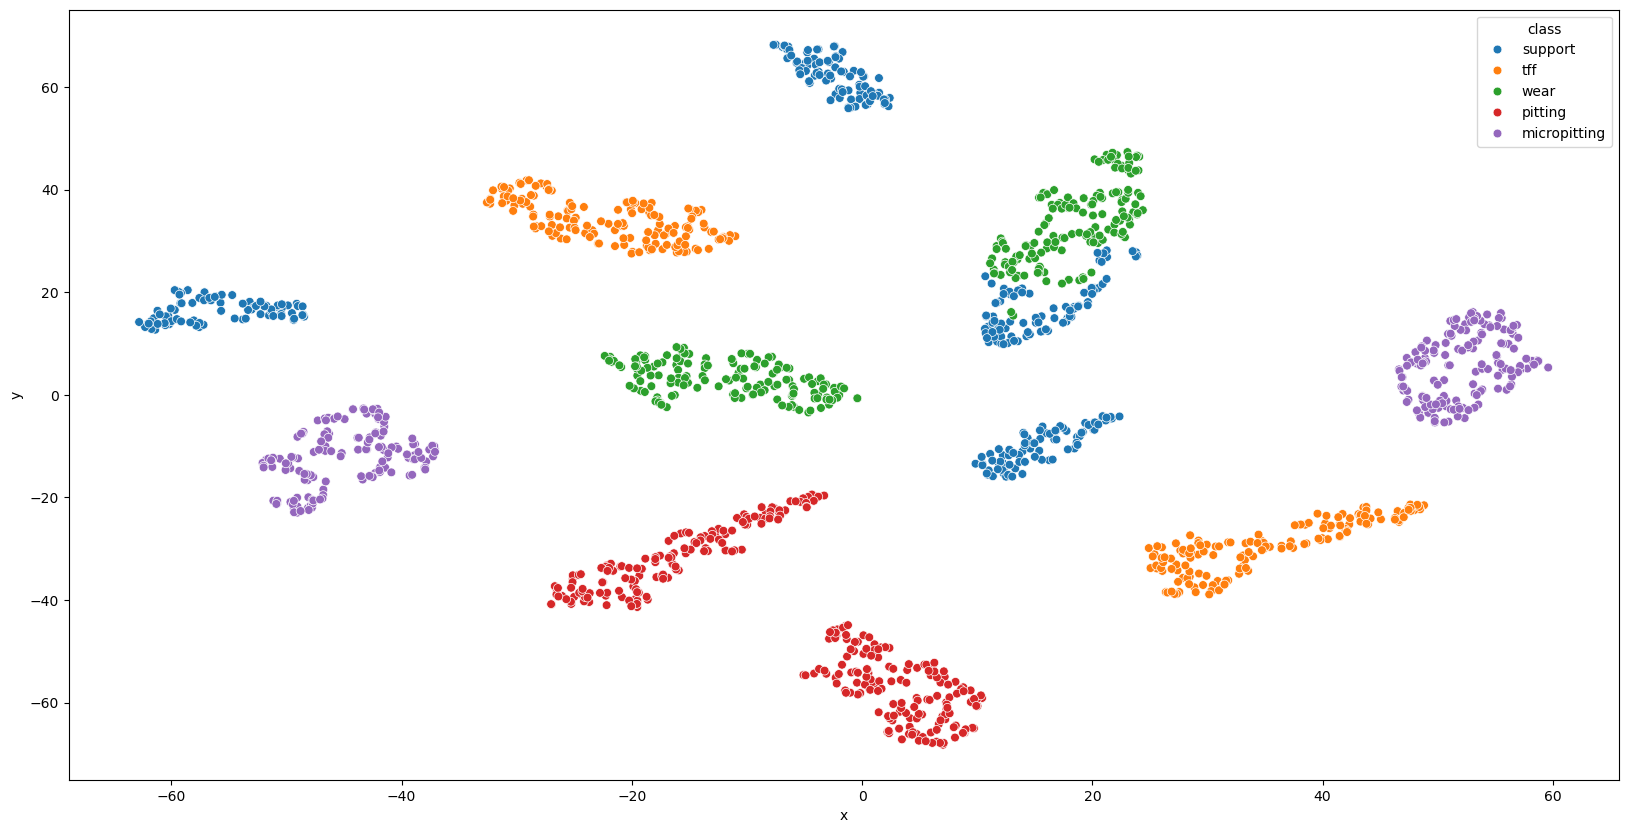

In [19]:
tsne_embeddings = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=20
).fit_transform(
    np.concatenate(
        [support_group, query_group, query_group_2, query_group_3, query_group_4]
    )
)
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["support"],
        len(query_group) * ["tff"],
        len(query_group_2) * ["wear"],
        len(query_group_3) * ["pitting"],
        len(query_group_4) * ["micropitting"],
    ]
)

plt.figure(figsize=(20, 10))
palette = sns.color_palette()

sns.scatterplot(
    tsne_embeddings,
    x="x",
    y="y",
    s=40,
    hue="class",
    palette=palette,
    alpha=1.0,
    legend=True,
)

In [20]:
tsne_embeddings = TSNE(
    n_components=3, learning_rate="auto", init="random", perplexity=20
).fit_transform(
    np.concatenate(
        [support_group, query_group, query_group_2, query_group_3, query_group_4]
    )
)
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y", "z"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["support"],
        len(query_group) * ["tff"],
        len(query_group_2) * ["wear"],
        len(query_group_3) * ["pitting"],
        len(query_group_4) * ["micropitting"],
    ]
)

fig = px.scatter_3d(
    tsne_embeddings, x="x", y="y", z="z", color="class", width=1200, height=1200
)
fig.show()

In [21]:
pca = PCA(n_components=3)
pca.fit(support_group[:50])

pca_embeddings = pca.transform(
    np.concatenate(
        [
            support_group,
            query_group_6,
            query_group,
            query_group_2,
            query_group_3,
            query_group_4,
            query_group_5,
        ]
    )
)

pca_embeddings = pd.DataFrame(pca_embeddings, columns=["x", "y", "z"])
pca_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["support"],
        len(query_group_6) * ["healthy"],
        len(query_group) * ["tff"],
        len(query_group_2) * ["wear"],
        len(query_group_3) * ["pitting"],
        len(query_group_4) * ["micropitting"],
        len(query_group_5) * ["mild tff"],
    ]
)


fig = px.scatter_3d(
    pca_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1200,
    height=1200,
    color_discrete_sequence=sns.color_palette("Paired").as_hex(),
)
fig.show()

## Distance thresholding


In [22]:
support_group = support_data[
    (support_data["rpm"] == 1500)
    & (support_data["GP"].isin([1, 2, 3, 4]))
    & (support_data["torque"] == 1)
].drop(["rpm", "GP", "torque"], axis=1)
support_group = support_group.to_numpy()

query_group = {}

query_group_baseline = query_data[
    (query_data["rpm"] == 1500)
    # & (query_data["severity"].isin(["5", "8", "9"]))
    # ! FIXME GPs 6 and 7 problematic why?
    & (query_data["severity"].isin(["5", "6", "7", "8", "9"]))
    & (query_data["torque"] == 1)
    & (query_data["installation"] == 0)
    & (query_data["fault"] == "baseline")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["baseline"] = query_group_baseline.to_numpy()

query_group_tff = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "tff")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["tff"] = query_group_tff.to_numpy()

query_group_mild_tff = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "mild")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "tff")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["mild_tff"] = query_group_mild_tff.to_numpy()

query_group_wear = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "wear")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["wear"] = query_group_wear.to_numpy()

query_group_pitting = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "pitting")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["pitting"] = query_group_pitting.to_numpy()

query_group_micropitting = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "micropitting")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["micropitting"] = query_group_micropitting.to_numpy()

### Raw distance


SUPPORT
Mean: 284203.4
Max: 794919.9
Min: 64831.215

baseline
Mean: 2686348.2
Max: 9524642.0
Min: 81452.74
mild_tff
Mean: 1466611.5
Max: 2343536.2
Min: 599408.06
tff
Mean: 42701184.0
Max: 135601070.0
Min: 13163798.0
micropitting
Mean: 8532213.0
Max: 18324992.0
Min: 1161437.8
pitting
Mean: 5623113.5
Max: 9232406.0
Min: 1763113.6
wear
Mean: 350861.34
Max: 731612.44
Min: 64104.336


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_69976/2274576752.py:31: UserWarning:

The palette list has more values (12) than needed (7), which may not be intended.



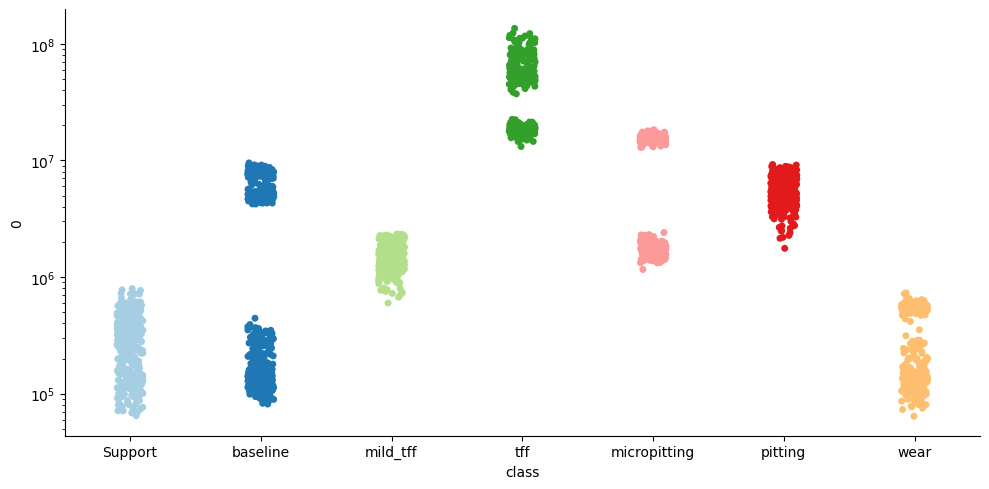

In [23]:
prototype = support_group.mean(axis=0)

print("SUPPORT")
support_distances = np.sum((support_group - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    print(fault)
    query_distances[fault] = np.sum((query_group[fault] - prototype) ** 2, axis=1)
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df,
    x="class",
    y=0,
    hue="class",
    log_scale=True,
    height=5,
    aspect=2,
    palette=sns.color_palette("Paired"),
    legend=False,
)

### STD scaled distance


SUPPORT
Mean: 63.853104
Max: 245.57063
Min: 15.81571

baseline
Mean: 513.15875
Max: 1723.5696
Min: 26.33206
mild_tff
Mean: 250.26807
Max: 417.69586
Min: 98.74089
tff
Mean: 21661.05
Max: 37699.156
Min: 12174.85
micropitting
Mean: 1662.2854
Max: 3562.3071
Min: 180.07896
pitting
Mean: 1104.7709
Max: 1902.5264
Min: 314.42163
wear
Mean: 92.59843
Max: 182.37373
Min: 18.066534


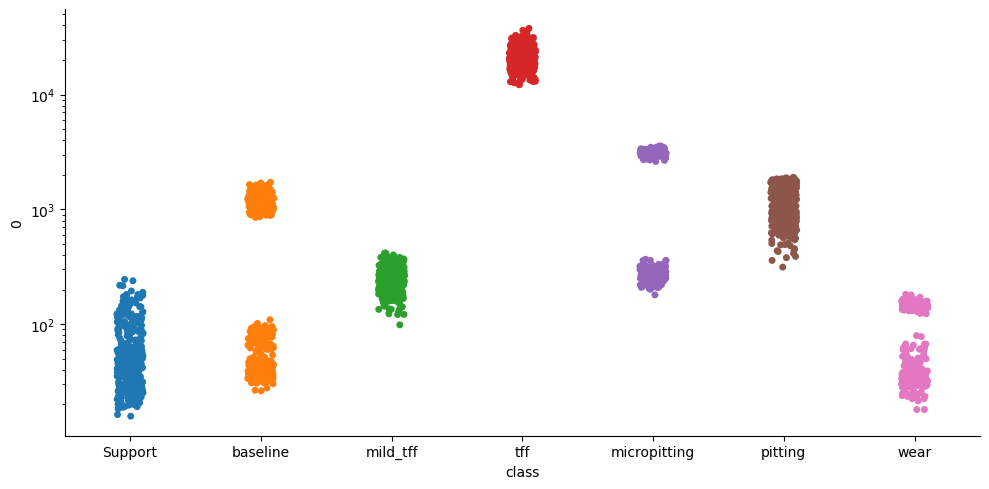

In [24]:
prototype = support_group.mean(axis=0)
prototype_std = support_group.std(axis=0)

prototype_std += 0.01  # Some stds are 0

print("SUPPORT")
support_distances = np.sum(((support_group - prototype) / prototype_std) ** 2, axis=1)
# support_distances = support_distances / prototype_std
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    print(fault)
    query_distances[fault] = np.sum(
        ((query_group[fault] - prototype) / prototype_std) ** 2, axis=1
    )
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df, x="class", y=0, hue="class", log_scale=True, height=5, aspect=2, legend=False
)

### Distance after PCA


(341, 5)
(5,)
SUPPORT
Mean: 282891.8
Max: 790609.75
Min: 63715.84

baseline
Mean: 2668191.0
Max: 9465446.0
Min: 79221.07

mild_tff
Mean: 1455084.9
Max: 2324417.8
Min: 591030.44

tff
Mean: 41453290.0
Max: 130277970.0
Min: 12678226.0

micropitting
Mean: 8494871.0
Max: 18259750.0
Min: 1153664.5

pitting
Mean: 5602508.0
Max: 9211996.0
Min: 1749229.9

wear
Mean: 343125.97
Max: 719074.6
Min: 62858.652



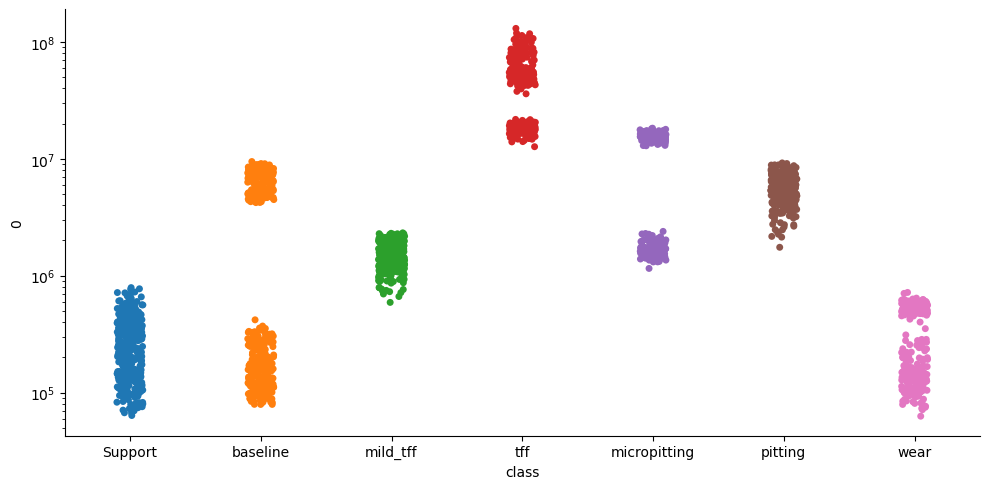

In [25]:
pca = PCA(n_components=5)
support_group_pca = pca.fit_transform(support_group)
print(support_group_pca.shape)


prototype = support_group_pca.mean(axis=0)
print(prototype.shape)

print("SUPPORT")
support_distances = np.sum((support_group_pca - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    print(fault)
    query_distances[fault] = np.sum(
        (pca.transform(query_group[fault]) - prototype) ** 2, axis=1
    )
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())
    print()

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df, x="class", y=0, hue="class", log_scale=True, height=5, aspect=2, legend=False
)

# ARotor


In [11]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

support_data = pd.read_feather(
    os.path.join(
        data_folder, "anomality_detection_arotor_10-18_17-35-55", "support_0.feather"
    )
)
query_data = pd.read_feather(
    os.path.join(
        data_folder, "anomality_detection_arotor_10-18_17-35-55", "query_0.feather"
    )
)

print("support", support_data.shape)
print("query", query_data.shape)

support (208, 66)
query (3952, 66)


In [12]:
support_group = support_data[(support_data["rpm"] == 1500)].drop(
    ["rpm", "class"], axis=1
)
support_group = support_group.to_numpy()

query_groups = {}

for i in range(10):
    query_group = query_data[
        (query_data["rpm"] == 1500) & (query_data["class"] == i)
    ].drop(["rpm", "class"], axis=1)
    query_groups[i] = query_group.to_numpy()

(52, 64)
(104, 64)


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_69976/1751696896.py:15: UserWarning:


The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.



<Axes: xlabel='x', ylabel='y'>

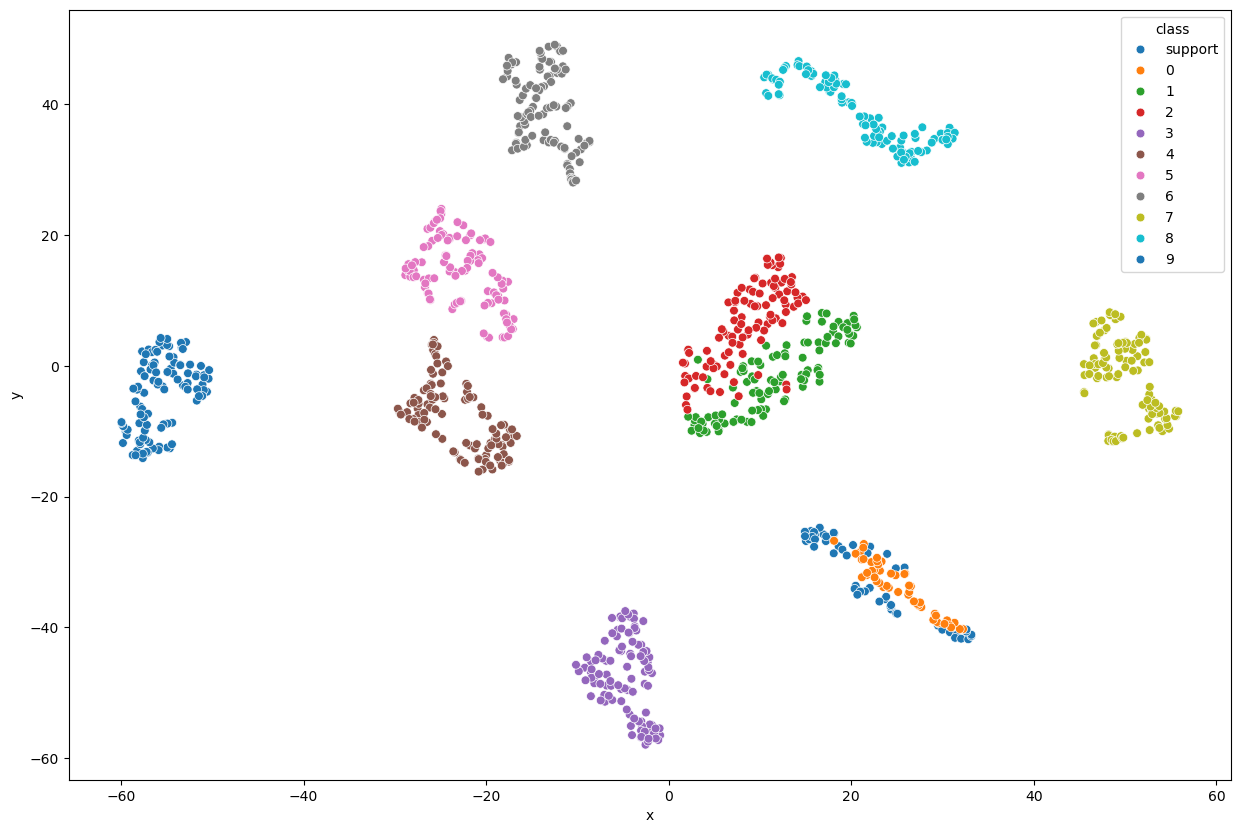

In [13]:
print(support_group.shape)
print(query_group.shape)

tsne_embeddings = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=20
).fit_transform(np.concatenate([support_group, *[query_groups[i] for i in range(10)]]))
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y"])
tsne_embeddings["class"] = np.concatenate(
    [len(support_group) * ["support"], *[len(query_groups[i]) * [i] for i in range(10)]]
)

plt.figure(figsize=(15, 10))
palette = sns.color_palette()

sns.scatterplot(
    tsne_embeddings,
    x="x",
    y="y",
    s=40,
    hue="class",
    palette=palette,
    alpha=1.0,
    legend=True,
)

In [ ]:
tsne_embeddings = TSNE(
    n_components=3, learning_rate="auto", init="random", perplexity=20
).fit_transform(np.concatenate([support_group, *[query_groups[i] for i in range(10)]]))
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y", "z"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["support"],
        *[len(query_groups[i]) * [i] for i in range(10)],
    ]
)

fig = px.scatter_3d(
    tsne_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1000,
    height=1000,
    color_discrete_sequence=px.colors.qualitative.Light24,
)
fig.show()

In [ ]:
pca = PCA(n_components=3)
pca.fit(support_group)

pca_embeddings = pca.transform(
    np.concatenate([support_group, *[query_groups[i] for i in range(10)]])
)

pca_embeddings = pd.DataFrame(pca_embeddings, columns=["x", "y", "z"])
pca_embeddings["class"] = np.concatenate(
    [len(support_group) * ["support"], *[len(query_groups[i]) * [i] for i in range(10)]]
)


fig = px.scatter_3d(
    pca_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1000,
    height=600,
    color_discrete_sequence=sns.color_palette("Paired").as_hex(),
    # color_discrete_sequence=px.colors.qualitative.Light24,
)
fig.show()

In [ ]:
str(sns.color_palette().as_hex())

"['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']"

### Distances


In [ ]:
support_group = support_data[(support_data["rpm"] == 1500)].drop(
    ["rpm", "class"], axis=1
)
support_group = support_group.to_numpy()

query_group = {}

for i in range(10):
    query_group_baseline = query_data[
        (query_data["rpm"] == 1500) & (query_data["class"] == i)
    ].drop(["rpm", "class"], axis=1)
    query_group["baseline"] = query_group_baseline.to_numpy()

SUPPORT
Mean: 6542.1953
Max: 30318.348
Min: 863.4813

0
Mean: 3713.5776
Max: 12462.372
Min: 1637.6204
1
Mean: 4100191.5
Max: 5851580.5
Min: 3012762.5
2
Mean: 4396277.0
Max: 6185351.5
Min: 3020712.0
3
Mean: 1794723.2
Max: 2658541.0
Min: 1046323.3
4
Mean: 184759.08
Max: 486035.88
Min: 98558.4
5
Mean: 470167.78
Max: 906059.9
Min: 184549.25
6
Mean: 928152.94
Max: 1499536.9
Min: 396398.88
7
Mean: 241784.47
Max: 411656.22
Min: 87098.234
8
Mean: 532484.8
Max: 818234.75
Min: 352948.75
9
Mean: 1229076.9
Max: 1843879.2
Min: 853211.1


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_56158/3284075337.py:31: UserWarning:

The palette list has more values (12) than needed (11), which may not be intended.



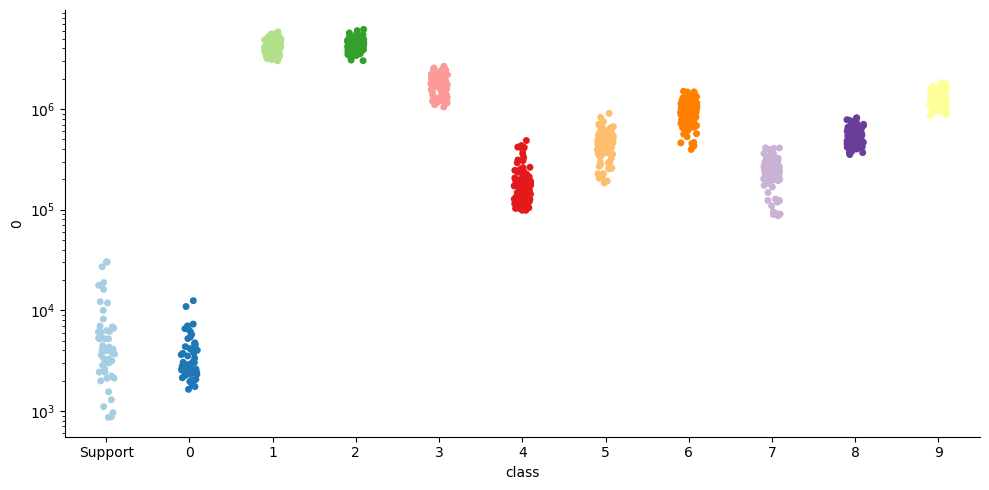

In [ ]:
prototype = support_group.mean(axis=0)

print("SUPPORT")
support_distances = np.sum((support_group - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in range(10):
    print(fault)
    query_distances[fault] = np.sum((query_groups[fault] - prototype) ** 2, axis=1)
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in range(10):
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df,
    x="class",
    y=0,
    hue="class",
    log_scale=True,
    height=5,
    aspect=2,
    legend=False,
    palette=sns.color_palette("Paired"),
)

(52, 5)
(5,)
SUPPORT
Mean: 6171.154
Max: 30053.492
Min: 557.91754

0
Mean: 2737.9983
Max: 11904.995
Min: 675.12946

1
Mean: 3810128.2
Max: 5371965.0
Min: 2813731.0

2
Mean: 4028095.5
Max: 5539995.0
Min: 2785049.0

3
Mean: 1663222.6
Max: 2454545.0
Min: 979221.3

4
Mean: 168045.5
Max: 458705.03
Min: 84806.29

5
Mean: 425348.7
Max: 806707.44
Min: 166935.22

6
Mean: 771405.9
Max: 1308005.4
Min: 326110.62

7
Mean: 210900.72
Max: 371079.72
Min: 76442.47

8
Mean: 351590.8
Max: 626976.1
Min: 205615.33

9
Mean: 816633.75
Max: 1276034.9
Min: 562547.8



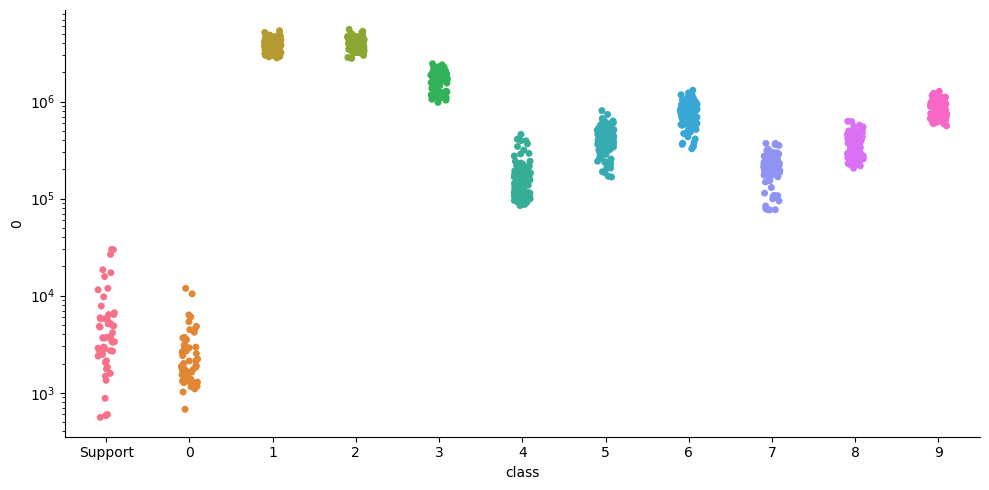

In [ ]:
pca = PCA(n_components=5)
support_group_pca = pca.fit_transform(support_group)
print(support_group_pca.shape)


prototype = support_group_pca.mean(axis=0)
print(prototype.shape)

print("SUPPORT")
support_distances = np.sum((support_group_pca - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in range(10):
    print(fault)
    query_distances[fault] = np.sum(
        (pca.transform(query_groups[fault]) - prototype) ** 2, axis=1
    )
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())
    print()

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in range(10):
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df, x="class", y=0, hue="class", log_scale=True, height=5, aspect=2, legend=False
)